## Segmentation map으로 도로 이미지 만들기

In [27]:
# 모듈 import
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

## 1. 데이터 준비

In [20]:
data_path = './data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


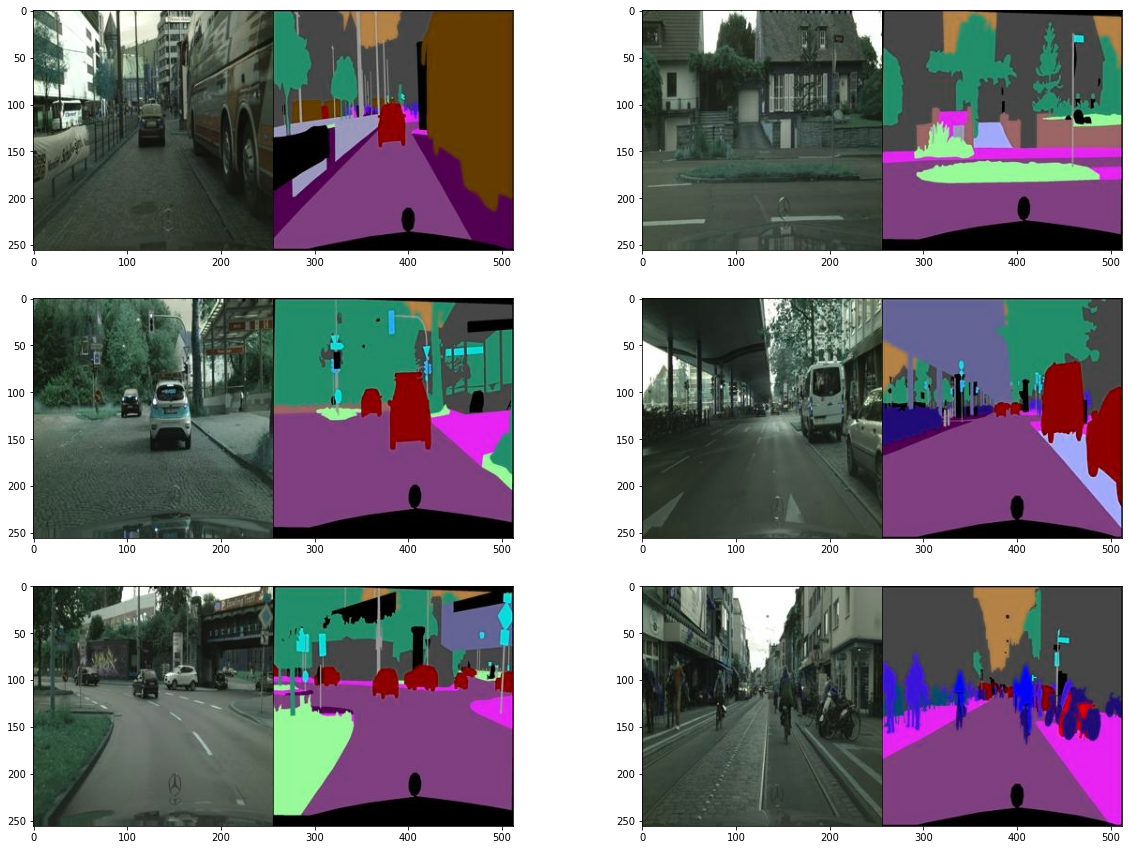

In [21]:
# 이미지 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [22]:
# 이미지 shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [23]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

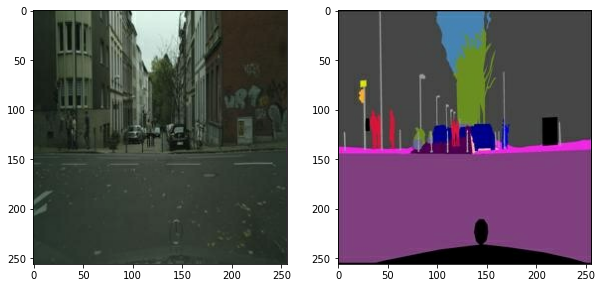

In [24]:
# 이미지 분리
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [25]:
# Augmentation 적용
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(sketch, colored):
    # 두 이미지를 채널 축으로 연결 (3채널인 경우 6채널로 변환)
    stacked = tf.concat([sketch, colored], axis=-1)

    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    # 50%의 확률로 Refection padding 또는 constant padding 적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 임의로 crop
    out = image.random_crop(padded, size=[256, 256, 6])

    # 50% 확률로 좌우상하 반전
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    # 50% 확률로 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)

    return out[...,:3], out[...,3:]

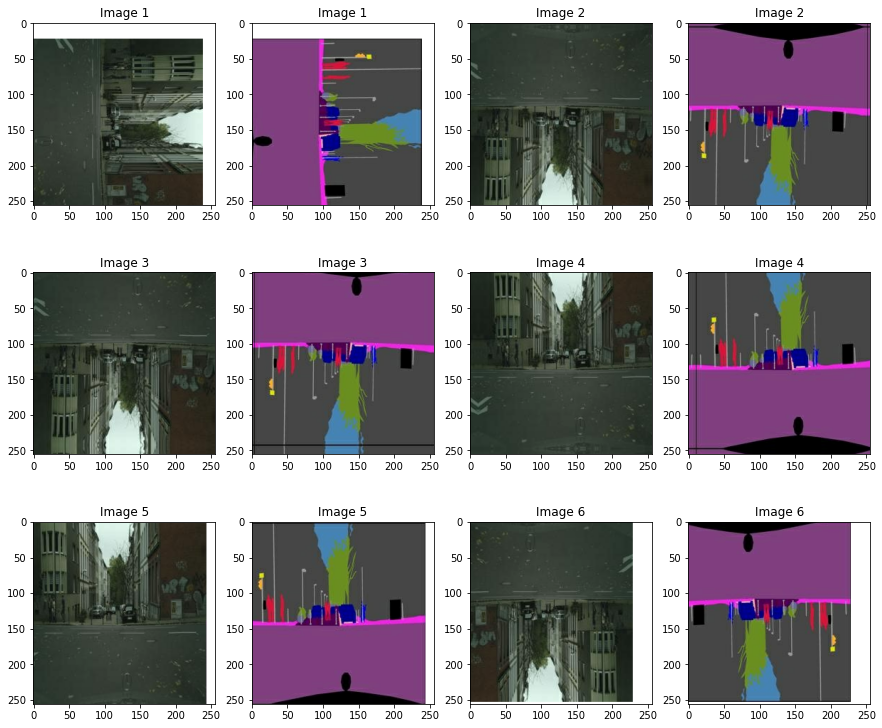

In [26]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [28]:
# 학습 노드에서 sketch와 colored 순서가 다름에 주의
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

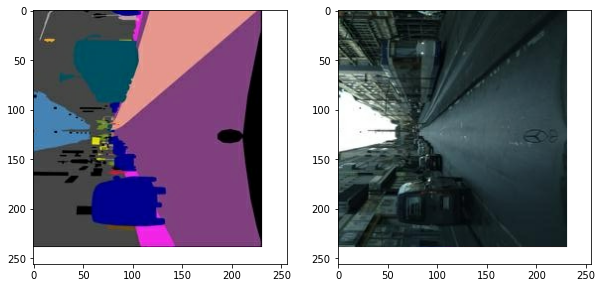

In [29]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. Generator

In [30]:
# Encoder
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [31]:
# Decoder   
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [32]:
# U-Net Generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # Encoder의 마지막 출력은 Decoder로 직접 입력되므로 Skip Connection에서 제외
        features = features[:-1]

        # feature의 역순으로 Skip Connection
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) # 가장 마지막 축(Channel) 기준으로 연결
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [33]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator 구성

In [34]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            # 1 만큼 ZeroPadding
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [35]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [36]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

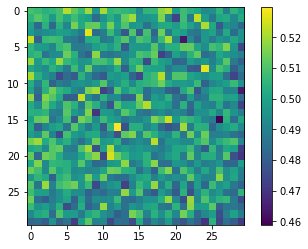

In [37]:
# 임의 테스트
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. 학습 및 테스트

In [39]:
# Loss Function
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [40]:
# Optimizer
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [41]:
# 학습 가중치 업데이트 함수
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [43]:
# 10 epoch 훈련
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")                    

EPOCH[1] - STEP[10]                     
Generator_loss:0.8827                     
L1_loss:0.3249                     
Discriminator_loss:1.1956

EPOCH[1] - STEP[20]                     
Generator_loss:0.9080                     
L1_loss:0.2286                     
Discriminator_loss:1.3602

EPOCH[1] - STEP[30]                     
Generator_loss:0.8562                     
L1_loss:0.1609                     
Discriminator_loss:1.4918

EPOCH[1] - STEP[40]                     
Generator_loss:0.8645                     
L1_loss:0.1811                     
Discriminator_loss:1.1944

EPOCH[1] - STEP[50]                     
Generator_loss:1.1217                     
L1_loss:0.1928                     
Discriminator_loss:1.2465

EPOCH[1] - STEP[60]                     
Generator_loss:1.0190                     
L1_loss:0.1809                     
Discriminator_loss:1.1000

EPOCH[1] - STEP[70]                     
Generator_loss:0.9442                     
L1_loss:0.1907                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.2321                     
L1_loss:0.2024                     
Discriminator_loss:0.6344

EPOCH[3] - STEP[80]                     
Generator_loss:0.4014                     
L1_loss:0.1851                     
Discriminator_loss:1.4448

EPOCH[3] - STEP[90]                     
Generator_loss:1.4698                     
L1_loss:0.1740                     
Discriminator_loss:0.8742

EPOCH[3] - STEP[100]                     
Generator_loss:2.2172                     
L1_loss:0.1450                     
Discriminator_loss:1.4591

EPOCH[3] - STEP[110]                     
Generator_loss:1.4753                     
L1_loss:0.1946                     
Discriminator_loss:0.4921

EPOCH[3] - STEP[120]                     
Generator_loss:0.3379                     
L1_loss:0.1674                     
Discriminator_loss:1.4959

EPOCH[3] - STEP[130]                     
Generator_loss:2.0266                     
L1_loss:0.1807                

EPOCH[5] - STEP[130]                     
Generator_loss:1.0302                     
L1_loss:0.1766                     
Discriminator_loss:0.8437

EPOCH[5] - STEP[140]                     
Generator_loss:1.8703                     
L1_loss:0.1725                     
Discriminator_loss:0.4259

EPOCH[5] - STEP[150]                     
Generator_loss:0.8119                     
L1_loss:0.1994                     
Discriminator_loss:1.1755

EPOCH[5] - STEP[160]                     
Generator_loss:0.3320                     
L1_loss:0.1854                     
Discriminator_loss:1.6593

EPOCH[5] - STEP[170]                     
Generator_loss:1.5365                     
L1_loss:0.1446                     
Discriminator_loss:0.7112

EPOCH[5] - STEP[180]                     
Generator_loss:1.5245                     
L1_loss:0.1938                     
Discriminator_loss:0.9732

EPOCH[5] - STEP[190]                     
Generator_loss:2.2016                     
L1_loss:0.1599             

EPOCH[7] - STEP[190]                     
Generator_loss:2.5633                     
L1_loss:0.1523                     
Discriminator_loss:1.4498

EPOCH[7] - STEP[200]                     
Generator_loss:1.0369                     
L1_loss:0.1933                     
Discriminator_loss:1.1723

EPOCH[7] - STEP[210]                     
Generator_loss:1.3441                     
L1_loss:0.1775                     
Discriminator_loss:0.7151

EPOCH[7] - STEP[220]                     
Generator_loss:1.1319                     
L1_loss:0.1653                     
Discriminator_loss:1.1068

EPOCH[7] - STEP[230]                     
Generator_loss:2.2947                     
L1_loss:0.2077                     
Discriminator_loss:0.2962

EPOCH[7] - STEP[240]                     
Generator_loss:0.7793                     
L1_loss:0.1635                     
Discriminator_loss:1.0113

EPOCH[7] - STEP[250]                     
Generator_loss:0.7229                     
L1_loss:0.1951             

EPOCH[9] - STEP[250]                     
Generator_loss:1.8877                     
L1_loss:0.1639                     
Discriminator_loss:0.3270

EPOCH[10] - STEP[10]                     
Generator_loss:1.0603                     
L1_loss:0.1696                     
Discriminator_loss:0.6552

EPOCH[10] - STEP[20]                     
Generator_loss:1.1715                     
L1_loss:0.1649                     
Discriminator_loss:3.0974

EPOCH[10] - STEP[30]                     
Generator_loss:0.7961                     
L1_loss:0.2165                     
Discriminator_loss:0.7644

EPOCH[10] - STEP[40]                     
Generator_loss:2.2900                     
L1_loss:0.1763                     
Discriminator_loss:0.3667

EPOCH[10] - STEP[50]                     
Generator_loss:2.1450                     
L1_loss:0.1551                     
Discriminator_loss:0.9935

EPOCH[10] - STEP[60]                     
Generator_loss:1.6524                     
L1_loss:0.1627             

In [44]:
val_path = './data/cityscapes/val/'
print("number of validation examples :", len(os.listdir(val_path)))

number of validation examples : 5


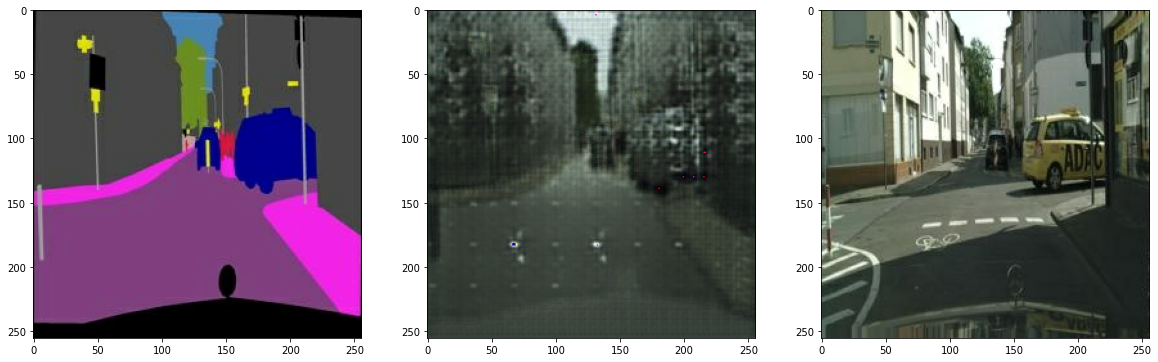

In [45]:
# 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [46]:
# 추가 100 epochs train
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:2.0036                     
L1_loss:0.1754                     
Discriminator_loss:0.5918

EPOCH[1] - STEP[100]                     
Generator_loss:1.0609                     
L1_loss:0.1819                     
Discriminator_loss:1.3931

EPOCH[1] - STEP[150]                     
Generator_loss:1.5343                     
L1_loss:0.1830                     
Discriminator_loss:1.5643

EPOCH[1] - STEP[200]                     
Generator_loss:0.7815                     
L1_loss:0.1445                     
Discriminator_loss:0.9633

EPOCH[1] - STEP[250]                     
Generator_loss:1.0741                     
L1_loss:0.2067                     
Discriminator_loss:0.7379

EPOCH[2] - STEP[50]                     
Generator_loss:1.8239                     
L1_loss:0.1882                     
Discriminator_loss:1.8427

EPOCH[2] - STEP[100]                     
Generator_loss:1.9742                     
L1_loss:0.1753               

EPOCH[12] - STEP[100]                     
Generator_loss:2.0268                     
L1_loss:0.1652                     
Discriminator_loss:0.9846

EPOCH[12] - STEP[150]                     
Generator_loss:0.5107                     
L1_loss:0.1674                     
Discriminator_loss:1.3808

EPOCH[12] - STEP[200]                     
Generator_loss:0.9155                     
L1_loss:0.2036                     
Discriminator_loss:0.5819

EPOCH[12] - STEP[250]                     
Generator_loss:1.1876                     
L1_loss:0.1816                     
Discriminator_loss:0.4524

EPOCH[13] - STEP[50]                     
Generator_loss:0.5818                     
L1_loss:0.1449                     
Discriminator_loss:1.1768

EPOCH[13] - STEP[100]                     
Generator_loss:0.8477                     
L1_loss:0.1869                     
Discriminator_loss:0.6708

EPOCH[13] - STEP[150]                     
Generator_loss:2.2179                     
L1_loss:0.1890       

EPOCH[23] - STEP[150]                     
Generator_loss:1.3709                     
L1_loss:0.1772                     
Discriminator_loss:2.1485

EPOCH[23] - STEP[200]                     
Generator_loss:0.9274                     
L1_loss:0.1799                     
Discriminator_loss:0.6093

EPOCH[23] - STEP[250]                     
Generator_loss:1.3030                     
L1_loss:0.1964                     
Discriminator_loss:0.4253

EPOCH[24] - STEP[50]                     
Generator_loss:0.8770                     
L1_loss:0.1969                     
Discriminator_loss:0.7435

EPOCH[24] - STEP[100]                     
Generator_loss:1.5457                     
L1_loss:0.1615                     
Discriminator_loss:1.6391

EPOCH[24] - STEP[150]                     
Generator_loss:1.8949                     
L1_loss:0.1920                     
Discriminator_loss:0.2764

EPOCH[24] - STEP[200]                     
Generator_loss:0.3736                     
L1_loss:0.1580       

EPOCH[34] - STEP[200]                     
Generator_loss:1.0273                     
L1_loss:0.1618                     
Discriminator_loss:1.7866

EPOCH[34] - STEP[250]                     
Generator_loss:2.1035                     
L1_loss:0.1391                     
Discriminator_loss:3.1099

EPOCH[35] - STEP[50]                     
Generator_loss:1.2119                     
L1_loss:0.1682                     
Discriminator_loss:0.6221

EPOCH[35] - STEP[100]                     
Generator_loss:2.1718                     
L1_loss:0.1658                     
Discriminator_loss:0.7577

EPOCH[35] - STEP[150]                     
Generator_loss:0.8825                     
L1_loss:0.1705                     
Discriminator_loss:1.2888

EPOCH[35] - STEP[200]                     
Generator_loss:1.5206                     
L1_loss:0.1535                     
Discriminator_loss:0.9139

EPOCH[35] - STEP[250]                     
Generator_loss:1.4023                     
L1_loss:0.1651       

EPOCH[45] - STEP[250]                     
Generator_loss:0.9135                     
L1_loss:0.1677                     
Discriminator_loss:1.5240

EPOCH[46] - STEP[50]                     
Generator_loss:1.4712                     
L1_loss:0.1670                     
Discriminator_loss:1.0206

EPOCH[46] - STEP[100]                     
Generator_loss:2.2304                     
L1_loss:0.1753                     
Discriminator_loss:0.5719

EPOCH[46] - STEP[150]                     
Generator_loss:1.9701                     
L1_loss:0.1655                     
Discriminator_loss:0.5365

EPOCH[46] - STEP[200]                     
Generator_loss:1.3640                     
L1_loss:0.1552                     
Discriminator_loss:2.0911

EPOCH[46] - STEP[250]                     
Generator_loss:1.3630                     
L1_loss:0.1712                     
Discriminator_loss:0.7268

EPOCH[47] - STEP[50]                     
Generator_loss:0.4542                     
L1_loss:0.1785        

EPOCH[57] - STEP[50]                     
Generator_loss:0.9658                     
L1_loss:0.1446                     
Discriminator_loss:1.1731

EPOCH[57] - STEP[100]                     
Generator_loss:1.1454                     
L1_loss:0.1723                     
Discriminator_loss:0.6484

EPOCH[57] - STEP[150]                     
Generator_loss:2.0141                     
L1_loss:0.1641                     
Discriminator_loss:1.3419

EPOCH[57] - STEP[200]                     
Generator_loss:1.7178                     
L1_loss:0.2343                     
Discriminator_loss:0.3320

EPOCH[57] - STEP[250]                     
Generator_loss:0.8723                     
L1_loss:0.1514                     
Discriminator_loss:1.5886

EPOCH[58] - STEP[50]                     
Generator_loss:0.8014                     
L1_loss:0.2006                     
Discriminator_loss:0.7976

EPOCH[58] - STEP[100]                     
Generator_loss:2.9192                     
L1_loss:0.1551        

EPOCH[68] - STEP[100]                     
Generator_loss:1.1542                     
L1_loss:0.1524                     
Discriminator_loss:0.8323

EPOCH[68] - STEP[150]                     
Generator_loss:1.0975                     
L1_loss:0.1822                     
Discriminator_loss:0.6616

EPOCH[68] - STEP[200]                     
Generator_loss:0.9579                     
L1_loss:0.1898                     
Discriminator_loss:0.6241

EPOCH[68] - STEP[250]                     
Generator_loss:0.6099                     
L1_loss:0.1684                     
Discriminator_loss:1.2160

EPOCH[69] - STEP[50]                     
Generator_loss:1.5014                     
L1_loss:0.2101                     
Discriminator_loss:0.3156

EPOCH[69] - STEP[100]                     
Generator_loss:1.7360                     
L1_loss:0.1815                     
Discriminator_loss:1.0025

EPOCH[69] - STEP[150]                     
Generator_loss:0.6085                     
L1_loss:0.1527       

EPOCH[79] - STEP[150]                     
Generator_loss:2.6078                     
L1_loss:0.1415                     
Discriminator_loss:1.7047

EPOCH[79] - STEP[200]                     
Generator_loss:2.1456                     
L1_loss:0.1548                     
Discriminator_loss:0.8512

EPOCH[79] - STEP[250]                     
Generator_loss:1.9554                     
L1_loss:0.1902                     
Discriminator_loss:0.7891

EPOCH[80] - STEP[50]                     
Generator_loss:2.3369                     
L1_loss:0.1566                     
Discriminator_loss:2.4217

EPOCH[80] - STEP[100]                     
Generator_loss:1.7065                     
L1_loss:0.1622                     
Discriminator_loss:0.5491

EPOCH[80] - STEP[150]                     
Generator_loss:0.9888                     
L1_loss:0.1794                     
Discriminator_loss:0.5389

EPOCH[80] - STEP[200]                     
Generator_loss:1.4810                     
L1_loss:0.1859       

EPOCH[90] - STEP[200]                     
Generator_loss:0.3940                     
L1_loss:0.1614                     
Discriminator_loss:1.5580

EPOCH[90] - STEP[250]                     
Generator_loss:2.2157                     
L1_loss:0.1761                     
Discriminator_loss:0.3647

EPOCH[91] - STEP[50]                     
Generator_loss:1.5855                     
L1_loss:0.2165                     
Discriminator_loss:0.2694

EPOCH[91] - STEP[100]                     
Generator_loss:2.1212                     
L1_loss:0.1590                     
Discriminator_loss:0.5583

EPOCH[91] - STEP[150]                     
Generator_loss:1.2258                     
L1_loss:0.1890                     
Discriminator_loss:0.4359

EPOCH[91] - STEP[200]                     
Generator_loss:0.5164                     
L1_loss:0.1751                     
Discriminator_loss:1.1021

EPOCH[91] - STEP[250]                     
Generator_loss:0.4345                     
L1_loss:0.1674       

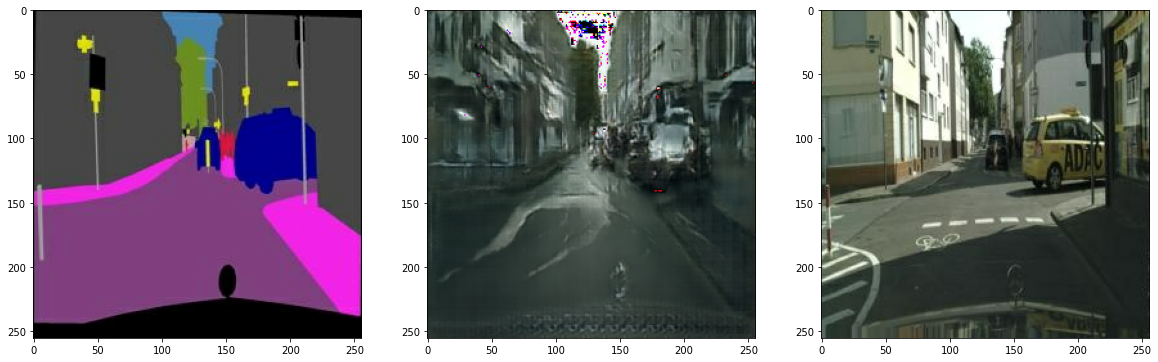

In [47]:
# 100 epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [49]:
# 추가 100 epochs train
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.0976                     
L1_loss:0.1453                     
Discriminator_loss:1.0922

EPOCH[1] - STEP[100]                     
Generator_loss:1.6336                     
L1_loss:0.1616                     
Discriminator_loss:1.1612

EPOCH[1] - STEP[150]                     
Generator_loss:0.9167                     
L1_loss:0.1630                     
Discriminator_loss:0.7398

EPOCH[1] - STEP[200]                     
Generator_loss:2.2709                     
L1_loss:0.1741                     
Discriminator_loss:0.9947

EPOCH[1] - STEP[250]                     
Generator_loss:1.4126                     
L1_loss:0.1629                     
Discriminator_loss:0.4485

EPOCH[2] - STEP[50]                     
Generator_loss:1.7072                     
L1_loss:0.1990                     
Discriminator_loss:0.2521

EPOCH[2] - STEP[100]                     
Generator_loss:1.1454                     
L1_loss:0.1449               

EPOCH[12] - STEP[100]                     
Generator_loss:1.4974                     
L1_loss:0.1930                     
Discriminator_loss:0.4277

EPOCH[12] - STEP[150]                     
Generator_loss:0.8863                     
L1_loss:0.1446                     
Discriminator_loss:1.4682

EPOCH[12] - STEP[200]                     
Generator_loss:1.7918                     
L1_loss:0.1729                     
Discriminator_loss:0.5635

EPOCH[12] - STEP[250]                     
Generator_loss:0.9058                     
L1_loss:0.1834                     
Discriminator_loss:0.7893

EPOCH[13] - STEP[50]                     
Generator_loss:1.0661                     
L1_loss:0.1714                     
Discriminator_loss:0.6638

EPOCH[13] - STEP[100]                     
Generator_loss:1.4290                     
L1_loss:0.1797                     
Discriminator_loss:0.5531

EPOCH[13] - STEP[150]                     
Generator_loss:1.7345                     
L1_loss:0.1808       

EPOCH[23] - STEP[150]                     
Generator_loss:1.0508                     
L1_loss:0.1680                     
Discriminator_loss:0.8863

EPOCH[23] - STEP[200]                     
Generator_loss:1.3939                     
L1_loss:0.1756                     
Discriminator_loss:0.3539

EPOCH[23] - STEP[250]                     
Generator_loss:1.4205                     
L1_loss:0.1757                     
Discriminator_loss:0.5571

EPOCH[24] - STEP[50]                     
Generator_loss:1.2319                     
L1_loss:0.1409                     
Discriminator_loss:1.2539

EPOCH[24] - STEP[100]                     
Generator_loss:0.7974                     
L1_loss:0.1586                     
Discriminator_loss:0.7943

EPOCH[24] - STEP[150]                     
Generator_loss:1.5580                     
L1_loss:0.1840                     
Discriminator_loss:1.6014

EPOCH[24] - STEP[200]                     
Generator_loss:1.5494                     
L1_loss:0.1518       

EPOCH[34] - STEP[200]                     
Generator_loss:2.7569                     
L1_loss:0.1849                     
Discriminator_loss:1.5140

EPOCH[34] - STEP[250]                     
Generator_loss:1.9102                     
L1_loss:0.1653                     
Discriminator_loss:1.0663

EPOCH[35] - STEP[50]                     
Generator_loss:1.3463                     
L1_loss:0.1498                     
Discriminator_loss:1.3962

EPOCH[35] - STEP[100]                     
Generator_loss:1.8378                     
L1_loss:0.1568                     
Discriminator_loss:0.6112

EPOCH[35] - STEP[150]                     
Generator_loss:2.0876                     
L1_loss:0.1599                     
Discriminator_loss:0.5413

EPOCH[35] - STEP[200]                     
Generator_loss:0.6437                     
L1_loss:0.1906                     
Discriminator_loss:1.0229

EPOCH[35] - STEP[250]                     
Generator_loss:0.9664                     
L1_loss:0.1865       

EPOCH[45] - STEP[250]                     
Generator_loss:0.9523                     
L1_loss:0.1479                     
Discriminator_loss:1.1482

EPOCH[46] - STEP[50]                     
Generator_loss:1.5254                     
L1_loss:0.1685                     
Discriminator_loss:1.8869

EPOCH[46] - STEP[100]                     
Generator_loss:1.1354                     
L1_loss:0.1760                     
Discriminator_loss:0.4877

EPOCH[46] - STEP[150]                     
Generator_loss:1.1943                     
L1_loss:0.1731                     
Discriminator_loss:1.8356

EPOCH[46] - STEP[200]                     
Generator_loss:1.6890                     
L1_loss:0.1799                     
Discriminator_loss:0.3151

EPOCH[46] - STEP[250]                     
Generator_loss:0.8878                     
L1_loss:0.1654                     
Discriminator_loss:0.7015

EPOCH[47] - STEP[50]                     
Generator_loss:0.4494                     
L1_loss:0.1602        

EPOCH[57] - STEP[50]                     
Generator_loss:1.5158                     
L1_loss:0.1838                     
Discriminator_loss:0.4733

EPOCH[57] - STEP[100]                     
Generator_loss:1.8444                     
L1_loss:0.1660                     
Discriminator_loss:2.4192

EPOCH[57] - STEP[150]                     
Generator_loss:1.2697                     
L1_loss:0.1617                     
Discriminator_loss:0.8573

EPOCH[57] - STEP[200]                     
Generator_loss:2.0633                     
L1_loss:0.1547                     
Discriminator_loss:0.7325

EPOCH[57] - STEP[250]                     
Generator_loss:1.1987                     
L1_loss:0.1603                     
Discriminator_loss:0.5680

EPOCH[58] - STEP[50]                     
Generator_loss:1.2512                     
L1_loss:0.1597                     
Discriminator_loss:0.4419

EPOCH[58] - STEP[100]                     
Generator_loss:1.6793                     
L1_loss:0.1916        

EPOCH[68] - STEP[100]                     
Generator_loss:1.5442                     
L1_loss:0.1778                     
Discriminator_loss:0.4513

EPOCH[68] - STEP[150]                     
Generator_loss:1.3513                     
L1_loss:0.1413                     
Discriminator_loss:1.6670

EPOCH[68] - STEP[200]                     
Generator_loss:0.7312                     
L1_loss:0.1807                     
Discriminator_loss:0.8207

EPOCH[68] - STEP[250]                     
Generator_loss:0.8878                     
L1_loss:0.1542                     
Discriminator_loss:1.1953

EPOCH[69] - STEP[50]                     
Generator_loss:1.1063                     
L1_loss:0.1673                     
Discriminator_loss:0.8154

EPOCH[69] - STEP[100]                     
Generator_loss:1.1666                     
L1_loss:0.1833                     
Discriminator_loss:0.6967

EPOCH[69] - STEP[150]                     
Generator_loss:2.1202                     
L1_loss:0.1572       

EPOCH[79] - STEP[150]                     
Generator_loss:1.4940                     
L1_loss:0.1388                     
Discriminator_loss:1.0909

EPOCH[79] - STEP[200]                     
Generator_loss:1.4607                     
L1_loss:0.1734                     
Discriminator_loss:0.3926

EPOCH[79] - STEP[250]                     
Generator_loss:0.9846                     
L1_loss:0.1345                     
Discriminator_loss:1.0637

EPOCH[80] - STEP[50]                     
Generator_loss:0.9372                     
L1_loss:0.1251                     
Discriminator_loss:1.4498

EPOCH[80] - STEP[100]                     
Generator_loss:1.7723                     
L1_loss:0.1529                     
Discriminator_loss:0.4398

EPOCH[80] - STEP[150]                     
Generator_loss:1.4091                     
L1_loss:0.1460                     
Discriminator_loss:0.8769

EPOCH[80] - STEP[200]                     
Generator_loss:0.8143                     
L1_loss:0.1850       

EPOCH[90] - STEP[200]                     
Generator_loss:3.0669                     
L1_loss:0.1617                     
Discriminator_loss:0.6806

EPOCH[90] - STEP[250]                     
Generator_loss:0.8300                     
L1_loss:0.1661                     
Discriminator_loss:1.2187

EPOCH[91] - STEP[50]                     
Generator_loss:1.4119                     
L1_loss:0.1544                     
Discriminator_loss:0.6909

EPOCH[91] - STEP[100]                     
Generator_loss:0.8651                     
L1_loss:0.1498                     
Discriminator_loss:1.1173

EPOCH[91] - STEP[150]                     
Generator_loss:2.0000                     
L1_loss:0.1510                     
Discriminator_loss:0.6892

EPOCH[91] - STEP[200]                     
Generator_loss:1.8406                     
L1_loss:0.1479                     
Discriminator_loss:1.9041

EPOCH[91] - STEP[250]                     
Generator_loss:2.2495                     
L1_loss:0.2079       

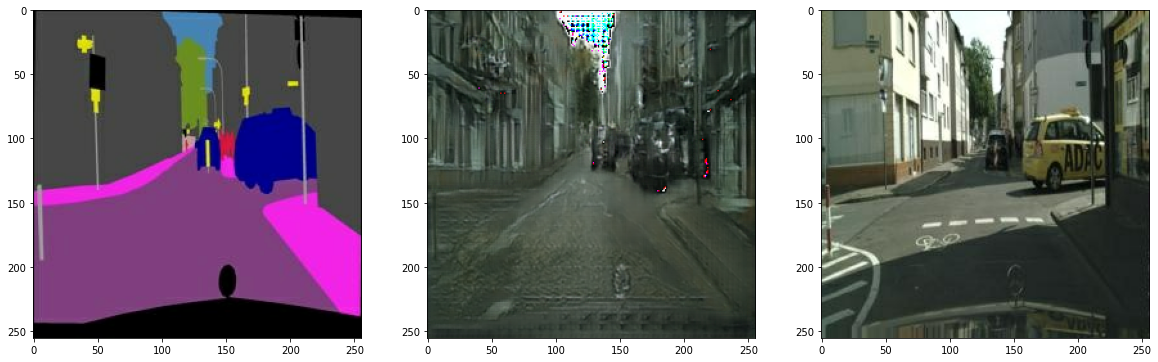

In [50]:
# 200epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [51]:
# 추가 200 epochs train
EPOCHS = 200

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.0579                     
L1_loss:0.1555                     
Discriminator_loss:1.2765

EPOCH[1] - STEP[100]                     
Generator_loss:2.2287                     
L1_loss:0.1398                     
Discriminator_loss:1.6690

EPOCH[1] - STEP[150]                     
Generator_loss:1.0967                     
L1_loss:0.1654                     
Discriminator_loss:0.6560

EPOCH[1] - STEP[200]                     
Generator_loss:1.3696                     
L1_loss:0.2048                     
Discriminator_loss:0.3692

EPOCH[1] - STEP[250]                     
Generator_loss:1.5423                     
L1_loss:0.1831                     
Discriminator_loss:0.4279

EPOCH[2] - STEP[50]                     
Generator_loss:0.7546                     
L1_loss:0.1806                     
Discriminator_loss:0.9709

EPOCH[2] - STEP[100]                     
Generator_loss:1.6330                     
L1_loss:0.1528               

EPOCH[12] - STEP[100]                     
Generator_loss:0.8111                     
L1_loss:0.1866                     
Discriminator_loss:0.7420

EPOCH[12] - STEP[150]                     
Generator_loss:0.5512                     
L1_loss:0.1659                     
Discriminator_loss:1.3226

EPOCH[12] - STEP[200]                     
Generator_loss:1.5259                     
L1_loss:0.1707                     
Discriminator_loss:0.5224

EPOCH[12] - STEP[250]                     
Generator_loss:1.3907                     
L1_loss:0.1438                     
Discriminator_loss:1.0158

EPOCH[13] - STEP[50]                     
Generator_loss:1.9361                     
L1_loss:0.1528                     
Discriminator_loss:0.9499

EPOCH[13] - STEP[100]                     
Generator_loss:0.9534                     
L1_loss:0.1516                     
Discriminator_loss:0.7252

EPOCH[13] - STEP[150]                     
Generator_loss:2.1743                     
L1_loss:0.1793       

EPOCH[23] - STEP[150]                     
Generator_loss:1.7105                     
L1_loss:0.1600                     
Discriminator_loss:0.5093

EPOCH[23] - STEP[200]                     
Generator_loss:1.0767                     
L1_loss:0.1605                     
Discriminator_loss:0.7282

EPOCH[23] - STEP[250]                     
Generator_loss:1.8184                     
L1_loss:0.1697                     
Discriminator_loss:0.3701

EPOCH[24] - STEP[50]                     
Generator_loss:0.7866                     
L1_loss:0.1452                     
Discriminator_loss:0.8953

EPOCH[24] - STEP[100]                     
Generator_loss:0.3864                     
L1_loss:0.1745                     
Discriminator_loss:1.5093

EPOCH[24] - STEP[150]                     
Generator_loss:2.8773                     
L1_loss:0.1533                     
Discriminator_loss:1.1080

EPOCH[24] - STEP[200]                     
Generator_loss:0.7269                     
L1_loss:0.1785       

EPOCH[34] - STEP[200]                     
Generator_loss:1.3357                     
L1_loss:0.1680                     
Discriminator_loss:0.6199

EPOCH[34] - STEP[250]                     
Generator_loss:0.3238                     
L1_loss:0.1427                     
Discriminator_loss:1.6693

EPOCH[35] - STEP[50]                     
Generator_loss:0.7103                     
L1_loss:0.1467                     
Discriminator_loss:1.3100

EPOCH[35] - STEP[100]                     
Generator_loss:1.7282                     
L1_loss:0.1667                     
Discriminator_loss:0.3523

EPOCH[35] - STEP[150]                     
Generator_loss:1.8329                     
L1_loss:0.1472                     
Discriminator_loss:0.8329

EPOCH[35] - STEP[200]                     
Generator_loss:1.9502                     
L1_loss:0.1973                     
Discriminator_loss:0.2208

EPOCH[35] - STEP[250]                     
Generator_loss:0.6243                     
L1_loss:0.1525       

EPOCH[45] - STEP[250]                     
Generator_loss:0.9121                     
L1_loss:0.1615                     
Discriminator_loss:1.9265

EPOCH[46] - STEP[50]                     
Generator_loss:1.1808                     
L1_loss:0.1599                     
Discriminator_loss:1.0264

EPOCH[46] - STEP[100]                     
Generator_loss:1.1368                     
L1_loss:0.1665                     
Discriminator_loss:1.4148

EPOCH[46] - STEP[150]                     
Generator_loss:1.4429                     
L1_loss:0.1910                     
Discriminator_loss:0.3651

EPOCH[46] - STEP[200]                     
Generator_loss:1.3282                     
L1_loss:0.1630                     
Discriminator_loss:0.5211

EPOCH[46] - STEP[250]                     
Generator_loss:1.1060                     
L1_loss:0.1416                     
Discriminator_loss:0.9988

EPOCH[47] - STEP[50]                     
Generator_loss:1.3117                     
L1_loss:0.1496        

EPOCH[57] - STEP[50]                     
Generator_loss:2.3180                     
L1_loss:0.1550                     
Discriminator_loss:0.2915

EPOCH[57] - STEP[100]                     
Generator_loss:2.2865                     
L1_loss:0.1556                     
Discriminator_loss:1.4185

EPOCH[57] - STEP[150]                     
Generator_loss:1.0944                     
L1_loss:0.1418                     
Discriminator_loss:1.2971

EPOCH[57] - STEP[200]                     
Generator_loss:2.1685                     
L1_loss:0.1749                     
Discriminator_loss:0.3875

EPOCH[57] - STEP[250]                     
Generator_loss:1.4698                     
L1_loss:0.1469                     
Discriminator_loss:0.7662

EPOCH[58] - STEP[50]                     
Generator_loss:0.8244                     
L1_loss:0.1498                     
Discriminator_loss:1.2517

EPOCH[58] - STEP[100]                     
Generator_loss:1.5250                     
L1_loss:0.1559        

EPOCH[68] - STEP[100]                     
Generator_loss:0.3205                     
L1_loss:0.1777                     
Discriminator_loss:1.7700

EPOCH[68] - STEP[150]                     
Generator_loss:1.0024                     
L1_loss:0.1560                     
Discriminator_loss:0.8016

EPOCH[68] - STEP[200]                     
Generator_loss:1.2884                     
L1_loss:0.1449                     
Discriminator_loss:0.5279

EPOCH[68] - STEP[250]                     
Generator_loss:0.7582                     
L1_loss:0.1625                     
Discriminator_loss:0.8938

EPOCH[69] - STEP[50]                     
Generator_loss:0.8431                     
L1_loss:0.1486                     
Discriminator_loss:1.2525

EPOCH[69] - STEP[100]                     
Generator_loss:2.1583                     
L1_loss:0.1739                     
Discriminator_loss:0.7040

EPOCH[69] - STEP[150]                     
Generator_loss:2.1318                     
L1_loss:0.1433       

EPOCH[79] - STEP[150]                     
Generator_loss:0.2488                     
L1_loss:0.1696                     
Discriminator_loss:1.8310

EPOCH[79] - STEP[200]                     
Generator_loss:1.6106                     
L1_loss:0.1596                     
Discriminator_loss:0.4870

EPOCH[79] - STEP[250]                     
Generator_loss:1.3497                     
L1_loss:0.1538                     
Discriminator_loss:0.9933

EPOCH[80] - STEP[50]                     
Generator_loss:2.2075                     
L1_loss:0.1477                     
Discriminator_loss:1.9355

EPOCH[80] - STEP[100]                     
Generator_loss:0.8106                     
L1_loss:0.1514                     
Discriminator_loss:0.7926

EPOCH[80] - STEP[150]                     
Generator_loss:2.3939                     
L1_loss:0.1594                     
Discriminator_loss:0.5911

EPOCH[80] - STEP[200]                     
Generator_loss:1.6574                     
L1_loss:0.1692       

EPOCH[90] - STEP[200]                     
Generator_loss:1.1868                     
L1_loss:0.1657                     
Discriminator_loss:0.6574

EPOCH[90] - STEP[250]                     
Generator_loss:2.2468                     
L1_loss:0.1446                     
Discriminator_loss:0.5767

EPOCH[91] - STEP[50]                     
Generator_loss:1.4797                     
L1_loss:0.1582                     
Discriminator_loss:2.8453

EPOCH[91] - STEP[100]                     
Generator_loss:0.9464                     
L1_loss:0.1544                     
Discriminator_loss:0.6678

EPOCH[91] - STEP[150]                     
Generator_loss:1.6767                     
L1_loss:0.1284                     
Discriminator_loss:1.6998

EPOCH[91] - STEP[200]                     
Generator_loss:0.8415                     
L1_loss:0.1998                     
Discriminator_loss:0.7634

EPOCH[91] - STEP[250]                     
Generator_loss:1.6877                     
L1_loss:0.1450       

EPOCH[101] - STEP[250]                     
Generator_loss:0.9801                     
L1_loss:0.1394                     
Discriminator_loss:1.4158

EPOCH[102] - STEP[50]                     
Generator_loss:1.9071                     
L1_loss:0.1741                     
Discriminator_loss:0.6283

EPOCH[102] - STEP[100]                     
Generator_loss:1.4832                     
L1_loss:0.1942                     
Discriminator_loss:0.3512

EPOCH[102] - STEP[150]                     
Generator_loss:0.9489                     
L1_loss:0.1631                     
Discriminator_loss:0.9311

EPOCH[102] - STEP[200]                     
Generator_loss:0.4372                     
L1_loss:0.1479                     
Discriminator_loss:1.8667

EPOCH[102] - STEP[250]                     
Generator_loss:0.7980                     
L1_loss:0.1716                     
Discriminator_loss:0.8271

EPOCH[103] - STEP[50]                     
Generator_loss:2.2578                     
L1_loss:0.1407 

EPOCH[112] - STEP[250]                     
Generator_loss:1.4896                     
L1_loss:0.1689                     
Discriminator_loss:1.2456

EPOCH[113] - STEP[50]                     
Generator_loss:2.0056                     
L1_loss:0.1461                     
Discriminator_loss:0.3224

EPOCH[113] - STEP[100]                     
Generator_loss:1.1376                     
L1_loss:0.1380                     
Discriminator_loss:1.2057

EPOCH[113] - STEP[150]                     
Generator_loss:1.2828                     
L1_loss:0.1635                     
Discriminator_loss:0.4951

EPOCH[113] - STEP[200]                     
Generator_loss:1.9630                     
L1_loss:0.1570                     
Discriminator_loss:0.8939

EPOCH[113] - STEP[250]                     
Generator_loss:1.0078                     
L1_loss:0.1642                     
Discriminator_loss:0.6499

EPOCH[114] - STEP[50]                     
Generator_loss:2.3378                     
L1_loss:0.1315 

EPOCH[123] - STEP[250]                     
Generator_loss:1.7918                     
L1_loss:0.1690                     
Discriminator_loss:0.2691

EPOCH[124] - STEP[50]                     
Generator_loss:1.8662                     
L1_loss:0.1490                     
Discriminator_loss:0.7900

EPOCH[124] - STEP[100]                     
Generator_loss:2.1874                     
L1_loss:0.1457                     
Discriminator_loss:0.8019

EPOCH[124] - STEP[150]                     
Generator_loss:1.3778                     
L1_loss:0.1643                     
Discriminator_loss:0.5407

EPOCH[124] - STEP[200]                     
Generator_loss:1.7891                     
L1_loss:0.1670                     
Discriminator_loss:0.2945

EPOCH[124] - STEP[250]                     
Generator_loss:3.0489                     
L1_loss:0.1591                     
Discriminator_loss:1.5224

EPOCH[125] - STEP[50]                     
Generator_loss:0.7058                     
L1_loss:0.1433 

EPOCH[134] - STEP[250]                     
Generator_loss:1.5626                     
L1_loss:0.1634                     
Discriminator_loss:0.4852

EPOCH[135] - STEP[50]                     
Generator_loss:0.7835                     
L1_loss:0.1671                     
Discriminator_loss:1.0801

EPOCH[135] - STEP[100]                     
Generator_loss:1.2259                     
L1_loss:0.1536                     
Discriminator_loss:2.1434

EPOCH[135] - STEP[150]                     
Generator_loss:0.9242                     
L1_loss:0.1624                     
Discriminator_loss:1.2069

EPOCH[135] - STEP[200]                     
Generator_loss:0.8725                     
L1_loss:0.1354                     
Discriminator_loss:1.0387

EPOCH[135] - STEP[250]                     
Generator_loss:1.4007                     
L1_loss:0.1543                     
Discriminator_loss:0.7526

EPOCH[136] - STEP[50]                     
Generator_loss:1.4648                     
L1_loss:0.1752 

EPOCH[145] - STEP[250]                     
Generator_loss:1.7288                     
L1_loss:0.1590                     
Discriminator_loss:0.5631

EPOCH[146] - STEP[50]                     
Generator_loss:1.0232                     
L1_loss:0.1654                     
Discriminator_loss:1.1150

EPOCH[146] - STEP[100]                     
Generator_loss:1.0882                     
L1_loss:0.1565                     
Discriminator_loss:0.8373

EPOCH[146] - STEP[150]                     
Generator_loss:2.0998                     
L1_loss:0.1183                     
Discriminator_loss:1.4151

EPOCH[146] - STEP[200]                     
Generator_loss:0.8311                     
L1_loss:0.1513                     
Discriminator_loss:0.9754

EPOCH[146] - STEP[250]                     
Generator_loss:1.5695                     
L1_loss:0.1468                     
Discriminator_loss:0.4834

EPOCH[147] - STEP[50]                     
Generator_loss:1.5827                     
L1_loss:0.1715 

EPOCH[156] - STEP[250]                     
Generator_loss:0.1623                     
L1_loss:0.1400                     
Discriminator_loss:2.5050

EPOCH[157] - STEP[50]                     
Generator_loss:1.3678                     
L1_loss:0.1544                     
Discriminator_loss:0.9829

EPOCH[157] - STEP[100]                     
Generator_loss:1.4085                     
L1_loss:0.1629                     
Discriminator_loss:0.5294

EPOCH[157] - STEP[150]                     
Generator_loss:1.3849                     
L1_loss:0.1717                     
Discriminator_loss:0.7818

EPOCH[157] - STEP[200]                     
Generator_loss:1.8475                     
L1_loss:0.1627                     
Discriminator_loss:0.3746

EPOCH[157] - STEP[250]                     
Generator_loss:1.5625                     
L1_loss:0.1552                     
Discriminator_loss:0.9691

EPOCH[158] - STEP[50]                     
Generator_loss:0.3562                     
L1_loss:0.1733 

EPOCH[167] - STEP[250]                     
Generator_loss:0.5022                     
L1_loss:0.1659                     
Discriminator_loss:1.1888

EPOCH[168] - STEP[50]                     
Generator_loss:2.2265                     
L1_loss:0.1635                     
Discriminator_loss:0.8406

EPOCH[168] - STEP[100]                     
Generator_loss:1.9161                     
L1_loss:0.1643                     
Discriminator_loss:0.3753

EPOCH[168] - STEP[150]                     
Generator_loss:1.1636                     
L1_loss:0.1639                     
Discriminator_loss:0.7030

EPOCH[168] - STEP[200]                     
Generator_loss:2.1360                     
L1_loss:0.1654                     
Discriminator_loss:0.4154

EPOCH[168] - STEP[250]                     
Generator_loss:0.9967                     
L1_loss:0.1484                     
Discriminator_loss:1.0214

EPOCH[169] - STEP[50]                     
Generator_loss:1.7958                     
L1_loss:0.1593 

EPOCH[178] - STEP[250]                     
Generator_loss:1.0639                     
L1_loss:0.1352                     
Discriminator_loss:1.2848

EPOCH[179] - STEP[50]                     
Generator_loss:2.6152                     
L1_loss:0.1823                     
Discriminator_loss:0.2755

EPOCH[179] - STEP[100]                     
Generator_loss:2.2378                     
L1_loss:0.1524                     
Discriminator_loss:0.6231

EPOCH[179] - STEP[150]                     
Generator_loss:0.8730                     
L1_loss:0.1844                     
Discriminator_loss:0.7599

EPOCH[179] - STEP[200]                     
Generator_loss:0.6747                     
L1_loss:0.1399                     
Discriminator_loss:1.2548

EPOCH[179] - STEP[250]                     
Generator_loss:1.8040                     
L1_loss:0.1710                     
Discriminator_loss:0.9377

EPOCH[180] - STEP[50]                     
Generator_loss:1.3100                     
L1_loss:0.1368 

EPOCH[189] - STEP[250]                     
Generator_loss:2.1852                     
L1_loss:0.1557                     
Discriminator_loss:0.5632

EPOCH[190] - STEP[50]                     
Generator_loss:1.0601                     
L1_loss:0.1559                     
Discriminator_loss:1.3124

EPOCH[190] - STEP[100]                     
Generator_loss:2.4102                     
L1_loss:0.1321                     
Discriminator_loss:1.6738

EPOCH[190] - STEP[150]                     
Generator_loss:1.4803                     
L1_loss:0.1819                     
Discriminator_loss:0.4631

EPOCH[190] - STEP[200]                     
Generator_loss:0.5806                     
L1_loss:0.1473                     
Discriminator_loss:1.1811

EPOCH[190] - STEP[250]                     
Generator_loss:1.0040                     
L1_loss:0.1263                     
Discriminator_loss:1.1441

EPOCH[191] - STEP[50]                     
Generator_loss:1.5945                     
L1_loss:0.1445 

EPOCH[200] - STEP[250]                     
Generator_loss:1.4081                     
L1_loss:0.1597                     
Discriminator_loss:0.4675



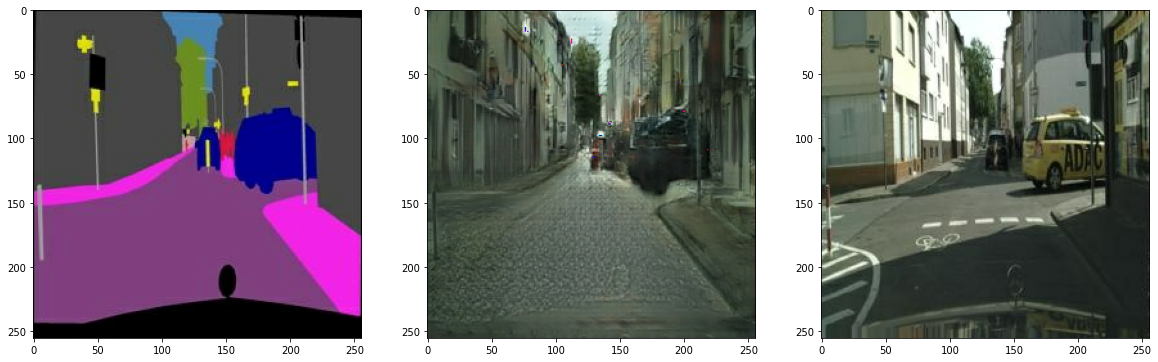

In [52]:
# 400epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [54]:
%%time
# 추가 100 epochs train
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:0.4906                     
L1_loss:0.1957                     
Discriminator_loss:1.3395

EPOCH[1] - STEP[100]                     
Generator_loss:1.5589                     
L1_loss:0.1267                     
Discriminator_loss:1.2407

EPOCH[1] - STEP[150]                     
Generator_loss:1.8336                     
L1_loss:0.1530                     
Discriminator_loss:0.5672

EPOCH[1] - STEP[200]                     
Generator_loss:2.4472                     
L1_loss:0.1612                     
Discriminator_loss:0.5897

EPOCH[1] - STEP[250]                     
Generator_loss:1.3551                     
L1_loss:0.1638                     
Discriminator_loss:0.5747

EPOCH[2] - STEP[50]                     
Generator_loss:1.3097                     
L1_loss:0.1693                     
Discriminator_loss:0.4961

EPOCH[2] - STEP[100]                     
Generator_loss:1.0113                     
L1_loss:0.1386               

EPOCH[12] - STEP[100]                     
Generator_loss:1.3990                     
L1_loss:0.1536                     
Discriminator_loss:0.6288

EPOCH[12] - STEP[150]                     
Generator_loss:0.4413                     
L1_loss:0.1302                     
Discriminator_loss:1.8719

EPOCH[12] - STEP[200]                     
Generator_loss:1.3589                     
L1_loss:0.1444                     
Discriminator_loss:0.7418

EPOCH[12] - STEP[250]                     
Generator_loss:1.7876                     
L1_loss:0.1402                     
Discriminator_loss:0.7287

EPOCH[13] - STEP[50]                     
Generator_loss:1.4240                     
L1_loss:0.1492                     
Discriminator_loss:1.0590

EPOCH[13] - STEP[100]                     
Generator_loss:2.3493                     
L1_loss:0.1389                     
Discriminator_loss:1.1814

EPOCH[13] - STEP[150]                     
Generator_loss:1.4733                     
L1_loss:0.1628       

EPOCH[23] - STEP[150]                     
Generator_loss:1.1644                     
L1_loss:0.1437                     
Discriminator_loss:0.9291

EPOCH[23] - STEP[200]                     
Generator_loss:3.5211                     
L1_loss:0.1291                     
Discriminator_loss:2.0747

EPOCH[23] - STEP[250]                     
Generator_loss:1.5967                     
L1_loss:0.1594                     
Discriminator_loss:0.4793

EPOCH[24] - STEP[50]                     
Generator_loss:2.3165                     
L1_loss:0.1222                     
Discriminator_loss:1.3382

EPOCH[24] - STEP[100]                     
Generator_loss:2.0616                     
L1_loss:0.1586                     
Discriminator_loss:0.2794

EPOCH[24] - STEP[150]                     
Generator_loss:0.5910                     
L1_loss:0.1626                     
Discriminator_loss:1.1353

EPOCH[24] - STEP[200]                     
Generator_loss:1.3189                     
L1_loss:0.1509       

EPOCH[34] - STEP[200]                     
Generator_loss:2.0876                     
L1_loss:0.1346                     
Discriminator_loss:0.7164

EPOCH[34] - STEP[250]                     
Generator_loss:2.7796                     
L1_loss:0.1464                     
Discriminator_loss:1.5957

EPOCH[35] - STEP[50]                     
Generator_loss:0.4734                     
L1_loss:0.1667                     
Discriminator_loss:1.3091

EPOCH[35] - STEP[100]                     
Generator_loss:1.1303                     
L1_loss:0.1345                     
Discriminator_loss:0.9314

EPOCH[35] - STEP[150]                     
Generator_loss:1.5093                     
L1_loss:0.1579                     
Discriminator_loss:1.3907

EPOCH[35] - STEP[200]                     
Generator_loss:2.4458                     
L1_loss:0.1504                     
Discriminator_loss:0.6970

EPOCH[35] - STEP[250]                     
Generator_loss:1.5906                     
L1_loss:0.1394       

EPOCH[45] - STEP[250]                     
Generator_loss:1.5630                     
L1_loss:0.1613                     
Discriminator_loss:0.5789

EPOCH[46] - STEP[50]                     
Generator_loss:1.4798                     
L1_loss:0.1525                     
Discriminator_loss:0.8737

EPOCH[46] - STEP[100]                     
Generator_loss:1.0669                     
L1_loss:0.1452                     
Discriminator_loss:1.0954

EPOCH[46] - STEP[150]                     
Generator_loss:2.1765                     
L1_loss:0.1472                     
Discriminator_loss:0.6615

EPOCH[46] - STEP[200]                     
Generator_loss:1.2199                     
L1_loss:0.1684                     
Discriminator_loss:0.5318

EPOCH[46] - STEP[250]                     
Generator_loss:2.9302                     
L1_loss:0.1470                     
Discriminator_loss:0.8181

EPOCH[47] - STEP[50]                     
Generator_loss:1.6278                     
L1_loss:0.1364        

EPOCH[57] - STEP[50]                     
Generator_loss:2.2703                     
L1_loss:0.1506                     
Discriminator_loss:0.2892

EPOCH[57] - STEP[100]                     
Generator_loss:1.7688                     
L1_loss:0.1832                     
Discriminator_loss:0.8621

EPOCH[57] - STEP[150]                     
Generator_loss:1.8353                     
L1_loss:0.1700                     
Discriminator_loss:0.3715

EPOCH[57] - STEP[200]                     
Generator_loss:0.5593                     
L1_loss:0.1586                     
Discriminator_loss:1.3094

EPOCH[57] - STEP[250]                     
Generator_loss:1.7838                     
L1_loss:0.1424                     
Discriminator_loss:1.3220

EPOCH[58] - STEP[50]                     
Generator_loss:0.3753                     
L1_loss:0.1691                     
Discriminator_loss:1.5640

EPOCH[58] - STEP[100]                     
Generator_loss:1.7932                     
L1_loss:0.1290        

EPOCH[68] - STEP[100]                     
Generator_loss:1.0883                     
L1_loss:0.1359                     
Discriminator_loss:0.6318

EPOCH[68] - STEP[150]                     
Generator_loss:2.7029                     
L1_loss:0.1372                     
Discriminator_loss:1.2493

EPOCH[68] - STEP[200]                     
Generator_loss:2.3563                     
L1_loss:0.1414                     
Discriminator_loss:1.9288

EPOCH[68] - STEP[250]                     
Generator_loss:2.1340                     
L1_loss:0.1302                     
Discriminator_loss:1.8489

EPOCH[69] - STEP[50]                     
Generator_loss:1.8201                     
L1_loss:0.1343                     
Discriminator_loss:1.4169

EPOCH[69] - STEP[100]                     
Generator_loss:2.4984                     
L1_loss:0.1511                     
Discriminator_loss:1.1669

EPOCH[69] - STEP[150]                     
Generator_loss:0.8804                     
L1_loss:0.1354       

EPOCH[79] - STEP[150]                     
Generator_loss:2.6722                     
L1_loss:0.1683                     
Discriminator_loss:0.2532

EPOCH[79] - STEP[200]                     
Generator_loss:2.5985                     
L1_loss:0.1526                     
Discriminator_loss:0.9054

EPOCH[79] - STEP[250]                     
Generator_loss:0.8175                     
L1_loss:0.1636                     
Discriminator_loss:0.8344

EPOCH[80] - STEP[50]                     
Generator_loss:1.2861                     
L1_loss:0.1534                     
Discriminator_loss:0.8016

EPOCH[80] - STEP[100]                     
Generator_loss:0.8926                     
L1_loss:0.1440                     
Discriminator_loss:1.0909

EPOCH[80] - STEP[150]                     
Generator_loss:1.9213                     
L1_loss:0.1432                     
Discriminator_loss:0.8389

EPOCH[80] - STEP[200]                     
Generator_loss:1.4385                     
L1_loss:0.1249       

EPOCH[90] - STEP[200]                     
Generator_loss:1.2520                     
L1_loss:0.1520                     
Discriminator_loss:1.3261

EPOCH[90] - STEP[250]                     
Generator_loss:0.7275                     
L1_loss:0.1248                     
Discriminator_loss:1.3363

EPOCH[91] - STEP[50]                     
Generator_loss:2.1985                     
L1_loss:0.1326                     
Discriminator_loss:1.3982

EPOCH[91] - STEP[100]                     
Generator_loss:2.2297                     
L1_loss:0.1446                     
Discriminator_loss:1.0375

EPOCH[91] - STEP[150]                     
Generator_loss:1.9355                     
L1_loss:0.1595                     
Discriminator_loss:0.5584

EPOCH[91] - STEP[200]                     
Generator_loss:0.8825                     
L1_loss:0.1295                     
Discriminator_loss:1.4760

EPOCH[91] - STEP[250]                     
Generator_loss:2.6451                     
L1_loss:0.1322       

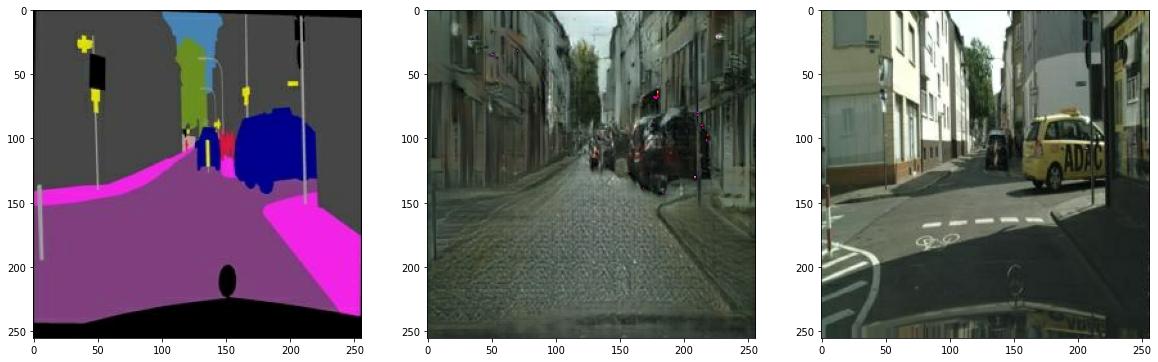

In [56]:
# 500epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [62]:
%%time
# 추가 100 epochs train
EPOCHS = 200

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.2423                     
L1_loss:0.1595                     
Discriminator_loss:0.5458

EPOCH[1] - STEP[100]                     
Generator_loss:0.7495                     
L1_loss:0.1383                     
Discriminator_loss:1.0831

EPOCH[1] - STEP[150]                     
Generator_loss:0.7446                     
L1_loss:0.1448                     
Discriminator_loss:0.9452

EPOCH[1] - STEP[200]                     
Generator_loss:2.3077                     
L1_loss:0.1528                     
Discriminator_loss:0.4687

EPOCH[1] - STEP[250]                     
Generator_loss:1.0544                     
L1_loss:0.1775                     
Discriminator_loss:0.6026

EPOCH[2] - STEP[50]                     
Generator_loss:2.4879                     
L1_loss:0.1549                     
Discriminator_loss:0.7570

EPOCH[2] - STEP[100]                     
Generator_loss:0.5442                     
L1_loss:0.1431               

EPOCH[12] - STEP[100]                     
Generator_loss:1.3296                     
L1_loss:0.1464                     
Discriminator_loss:0.6514

EPOCH[12] - STEP[150]                     
Generator_loss:1.2779                     
L1_loss:0.1473                     
Discriminator_loss:1.2705

EPOCH[12] - STEP[200]                     
Generator_loss:2.7210                     
L1_loss:0.1455                     
Discriminator_loss:0.9884

EPOCH[12] - STEP[250]                     
Generator_loss:1.4913                     
L1_loss:0.1419                     
Discriminator_loss:0.8075

EPOCH[13] - STEP[50]                     
Generator_loss:0.6018                     
L1_loss:0.1445                     
Discriminator_loss:1.2666

EPOCH[13] - STEP[100]                     
Generator_loss:1.9709                     
L1_loss:0.1429                     
Discriminator_loss:0.4879

EPOCH[13] - STEP[150]                     
Generator_loss:1.9207                     
L1_loss:0.1614       

EPOCH[23] - STEP[150]                     
Generator_loss:1.0101                     
L1_loss:0.1652                     
Discriminator_loss:0.6376

EPOCH[23] - STEP[200]                     
Generator_loss:2.4435                     
L1_loss:0.1704                     
Discriminator_loss:0.5919

EPOCH[23] - STEP[250]                     
Generator_loss:1.9180                     
L1_loss:0.1157                     
Discriminator_loss:1.2263

EPOCH[24] - STEP[50]                     
Generator_loss:1.7726                     
L1_loss:0.1534                     
Discriminator_loss:0.5502

EPOCH[24] - STEP[100]                     
Generator_loss:1.9833                     
L1_loss:0.1384                     
Discriminator_loss:0.8703

EPOCH[24] - STEP[150]                     
Generator_loss:1.4218                     
L1_loss:0.1612                     
Discriminator_loss:0.5412

EPOCH[24] - STEP[200]                     
Generator_loss:2.4236                     
L1_loss:0.1642       

EPOCH[34] - STEP[200]                     
Generator_loss:1.1460                     
L1_loss:0.1288                     
Discriminator_loss:0.9660

EPOCH[34] - STEP[250]                     
Generator_loss:2.4528                     
L1_loss:0.1525                     
Discriminator_loss:0.8890

EPOCH[35] - STEP[50]                     
Generator_loss:1.0763                     
L1_loss:0.1438                     
Discriminator_loss:0.8366

EPOCH[35] - STEP[100]                     
Generator_loss:1.6397                     
L1_loss:0.1522                     
Discriminator_loss:0.8780

EPOCH[35] - STEP[150]                     
Generator_loss:1.9306                     
L1_loss:0.1532                     
Discriminator_loss:0.4036

EPOCH[35] - STEP[200]                     
Generator_loss:2.0521                     
L1_loss:0.1337                     
Discriminator_loss:1.1044

EPOCH[35] - STEP[250]                     
Generator_loss:0.8347                     
L1_loss:0.1761       

EPOCH[45] - STEP[250]                     
Generator_loss:1.7578                     
L1_loss:0.1381                     
Discriminator_loss:0.4424

EPOCH[46] - STEP[50]                     
Generator_loss:1.1237                     
L1_loss:0.1369                     
Discriminator_loss:0.9327

EPOCH[46] - STEP[100]                     
Generator_loss:1.9439                     
L1_loss:0.1759                     
Discriminator_loss:0.5711

EPOCH[46] - STEP[150]                     
Generator_loss:3.4971                     
L1_loss:0.1378                     
Discriminator_loss:1.7778

EPOCH[46] - STEP[200]                     
Generator_loss:1.1733                     
L1_loss:0.1560                     
Discriminator_loss:0.6547

EPOCH[46] - STEP[250]                     
Generator_loss:1.8880                     
L1_loss:0.1461                     
Discriminator_loss:1.3268

EPOCH[47] - STEP[50]                     
Generator_loss:1.5093                     
L1_loss:0.1479        

EPOCH[57] - STEP[50]                     
Generator_loss:1.7144                     
L1_loss:0.1744                     
Discriminator_loss:0.4334

EPOCH[57] - STEP[100]                     
Generator_loss:1.7233                     
L1_loss:0.1439                     
Discriminator_loss:0.4577

EPOCH[57] - STEP[150]                     
Generator_loss:2.1248                     
L1_loss:0.1493                     
Discriminator_loss:0.6275

EPOCH[57] - STEP[200]                     
Generator_loss:3.4261                     
L1_loss:0.1289                     
Discriminator_loss:1.4460

EPOCH[57] - STEP[250]                     
Generator_loss:2.2253                     
L1_loss:0.1410                     
Discriminator_loss:1.0977

EPOCH[58] - STEP[50]                     
Generator_loss:1.7202                     
L1_loss:0.1334                     
Discriminator_loss:1.0773

EPOCH[58] - STEP[100]                     
Generator_loss:1.6432                     
L1_loss:0.1365        

EPOCH[68] - STEP[100]                     
Generator_loss:0.5489                     
L1_loss:0.1577                     
Discriminator_loss:1.4224

EPOCH[68] - STEP[150]                     
Generator_loss:2.2617                     
L1_loss:0.1507                     
Discriminator_loss:0.5830

EPOCH[68] - STEP[200]                     
Generator_loss:1.3454                     
L1_loss:0.1548                     
Discriminator_loss:0.7098

EPOCH[68] - STEP[250]                     
Generator_loss:2.4373                     
L1_loss:0.1463                     
Discriminator_loss:0.6738

EPOCH[69] - STEP[50]                     
Generator_loss:1.3948                     
L1_loss:0.1429                     
Discriminator_loss:0.5659

EPOCH[69] - STEP[100]                     
Generator_loss:0.8009                     
L1_loss:0.1444                     
Discriminator_loss:1.1184

EPOCH[69] - STEP[150]                     
Generator_loss:1.1970                     
L1_loss:0.1399       

EPOCH[79] - STEP[150]                     
Generator_loss:1.9967                     
L1_loss:0.1399                     
Discriminator_loss:0.5228

EPOCH[79] - STEP[200]                     
Generator_loss:1.2731                     
L1_loss:0.1477                     
Discriminator_loss:1.4896

EPOCH[79] - STEP[250]                     
Generator_loss:2.2153                     
L1_loss:0.1307                     
Discriminator_loss:0.8911

EPOCH[80] - STEP[50]                     
Generator_loss:1.3795                     
L1_loss:0.1099                     
Discriminator_loss:1.0877

EPOCH[80] - STEP[100]                     
Generator_loss:1.2812                     
L1_loss:0.1394                     
Discriminator_loss:0.7246

EPOCH[80] - STEP[150]                     
Generator_loss:2.0332                     
L1_loss:0.1405                     
Discriminator_loss:1.6403

EPOCH[80] - STEP[200]                     
Generator_loss:1.8539                     
L1_loss:0.1562       

EPOCH[90] - STEP[200]                     
Generator_loss:3.5010                     
L1_loss:0.1877                     
Discriminator_loss:0.0773

EPOCH[90] - STEP[250]                     
Generator_loss:3.2905                     
L1_loss:0.1240                     
Discriminator_loss:0.9864

EPOCH[91] - STEP[50]                     
Generator_loss:1.7766                     
L1_loss:0.1417                     
Discriminator_loss:1.6417

EPOCH[91] - STEP[100]                     
Generator_loss:1.5001                     
L1_loss:0.1490                     
Discriminator_loss:0.5416

EPOCH[91] - STEP[150]                     
Generator_loss:0.9889                     
L1_loss:0.1390                     
Discriminator_loss:0.9985

EPOCH[91] - STEP[200]                     
Generator_loss:2.5768                     
L1_loss:0.1348                     
Discriminator_loss:1.7325

EPOCH[91] - STEP[250]                     
Generator_loss:3.5961                     
L1_loss:0.1726       

EPOCH[101] - STEP[250]                     
Generator_loss:1.1231                     
L1_loss:0.1873                     
Discriminator_loss:0.6387

EPOCH[102] - STEP[50]                     
Generator_loss:1.9284                     
L1_loss:0.1330                     
Discriminator_loss:0.9701

EPOCH[102] - STEP[100]                     
Generator_loss:2.7316                     
L1_loss:0.1400                     
Discriminator_loss:0.7056

EPOCH[102] - STEP[150]                     
Generator_loss:1.2291                     
L1_loss:0.1475                     
Discriminator_loss:0.5881

EPOCH[102] - STEP[200]                     
Generator_loss:1.1151                     
L1_loss:0.1514                     
Discriminator_loss:0.7712

EPOCH[102] - STEP[250]                     
Generator_loss:1.4456                     
L1_loss:0.1685                     
Discriminator_loss:0.8845

EPOCH[103] - STEP[50]                     
Generator_loss:0.9772                     
L1_loss:0.1631 

EPOCH[112] - STEP[250]                     
Generator_loss:0.7587                     
L1_loss:0.1232                     
Discriminator_loss:1.1325

EPOCH[113] - STEP[50]                     
Generator_loss:1.6594                     
L1_loss:0.1418                     
Discriminator_loss:0.9485

EPOCH[113] - STEP[100]                     
Generator_loss:1.9849                     
L1_loss:0.1569                     
Discriminator_loss:0.3798

EPOCH[113] - STEP[150]                     
Generator_loss:2.3159                     
L1_loss:0.1553                     
Discriminator_loss:0.3068

EPOCH[113] - STEP[200]                     
Generator_loss:1.5575                     
L1_loss:0.1530                     
Discriminator_loss:0.6012

EPOCH[113] - STEP[250]                     
Generator_loss:2.5819                     
L1_loss:0.1422                     
Discriminator_loss:0.9251

EPOCH[114] - STEP[50]                     
Generator_loss:0.9110                     
L1_loss:0.1264 

EPOCH[123] - STEP[250]                     
Generator_loss:0.8840                     
L1_loss:0.1309                     
Discriminator_loss:0.9673

EPOCH[124] - STEP[50]                     
Generator_loss:1.2197                     
L1_loss:0.1384                     
Discriminator_loss:0.8967

EPOCH[124] - STEP[100]                     
Generator_loss:1.3993                     
L1_loss:0.1489                     
Discriminator_loss:0.7514

EPOCH[124] - STEP[150]                     
Generator_loss:1.0940                     
L1_loss:0.1388                     
Discriminator_loss:0.9395

EPOCH[124] - STEP[200]                     
Generator_loss:2.5937                     
L1_loss:0.1596                     
Discriminator_loss:1.0706

EPOCH[124] - STEP[250]                     
Generator_loss:1.5571                     
L1_loss:0.1757                     
Discriminator_loss:0.4684

EPOCH[125] - STEP[50]                     
Generator_loss:1.9283                     
L1_loss:0.1522 

EPOCH[134] - STEP[250]                     
Generator_loss:0.6797                     
L1_loss:0.1642                     
Discriminator_loss:1.1949

EPOCH[135] - STEP[50]                     
Generator_loss:2.0832                     
L1_loss:0.1451                     
Discriminator_loss:0.8069

EPOCH[135] - STEP[100]                     
Generator_loss:1.6839                     
L1_loss:0.1583                     
Discriminator_loss:0.4496

EPOCH[135] - STEP[150]                     
Generator_loss:0.9751                     
L1_loss:0.1534                     
Discriminator_loss:0.7741

EPOCH[135] - STEP[200]                     
Generator_loss:2.9435                     
L1_loss:0.1389                     
Discriminator_loss:0.9986

EPOCH[135] - STEP[250]                     
Generator_loss:1.6011                     
L1_loss:0.1395                     
Discriminator_loss:0.5796

EPOCH[136] - STEP[50]                     
Generator_loss:2.6313                     
L1_loss:0.1251 

EPOCH[145] - STEP[250]                     
Generator_loss:1.1741                     
L1_loss:0.1507                     
Discriminator_loss:0.6121

EPOCH[146] - STEP[50]                     
Generator_loss:1.7961                     
L1_loss:0.1459                     
Discriminator_loss:0.6087

EPOCH[146] - STEP[100]                     
Generator_loss:2.1727                     
L1_loss:0.1444                     
Discriminator_loss:0.7255

EPOCH[146] - STEP[150]                     
Generator_loss:1.5246                     
L1_loss:0.1273                     
Discriminator_loss:0.6754

EPOCH[146] - STEP[200]                     
Generator_loss:2.1424                     
L1_loss:0.1466                     
Discriminator_loss:1.0337

EPOCH[146] - STEP[250]                     
Generator_loss:2.2386                     
L1_loss:0.1452                     
Discriminator_loss:0.8864

EPOCH[147] - STEP[50]                     
Generator_loss:2.3248                     
L1_loss:0.1402 

EPOCH[156] - STEP[250]                     
Generator_loss:1.4767                     
L1_loss:0.1650                     
Discriminator_loss:0.8228

EPOCH[157] - STEP[50]                     
Generator_loss:1.4845                     
L1_loss:0.1367                     
Discriminator_loss:0.8494

EPOCH[157] - STEP[100]                     
Generator_loss:1.5020                     
L1_loss:0.1316                     
Discriminator_loss:0.9912

EPOCH[157] - STEP[150]                     
Generator_loss:1.1180                     
L1_loss:0.1585                     
Discriminator_loss:0.6620

EPOCH[157] - STEP[200]                     
Generator_loss:2.4902                     
L1_loss:0.1257                     
Discriminator_loss:1.2528

EPOCH[157] - STEP[250]                     
Generator_loss:2.4715                     
L1_loss:0.1582                     
Discriminator_loss:0.4621

EPOCH[158] - STEP[50]                     
Generator_loss:2.0433                     
L1_loss:0.1454 

EPOCH[167] - STEP[250]                     
Generator_loss:2.0243                     
L1_loss:0.1435                     
Discriminator_loss:0.8669

EPOCH[168] - STEP[50]                     
Generator_loss:0.7231                     
L1_loss:0.1382                     
Discriminator_loss:1.1765

EPOCH[168] - STEP[100]                     
Generator_loss:1.4108                     
L1_loss:0.1270                     
Discriminator_loss:1.1016

EPOCH[168] - STEP[150]                     
Generator_loss:0.9302                     
L1_loss:0.1668                     
Discriminator_loss:0.7761

EPOCH[168] - STEP[200]                     
Generator_loss:1.7978                     
L1_loss:0.1130                     
Discriminator_loss:1.0584

EPOCH[168] - STEP[250]                     
Generator_loss:1.0088                     
L1_loss:0.1664                     
Discriminator_loss:0.7669

EPOCH[169] - STEP[50]                     
Generator_loss:2.1622                     
L1_loss:0.1336 

EPOCH[178] - STEP[250]                     
Generator_loss:1.4685                     
L1_loss:0.1557                     
Discriminator_loss:0.5631

EPOCH[179] - STEP[50]                     
Generator_loss:1.2200                     
L1_loss:0.1300                     
Discriminator_loss:0.8927

EPOCH[179] - STEP[100]                     
Generator_loss:1.9659                     
L1_loss:0.2096                     
Discriminator_loss:0.3679

EPOCH[179] - STEP[150]                     
Generator_loss:2.0274                     
L1_loss:0.1383                     
Discriminator_loss:0.8202

EPOCH[179] - STEP[200]                     
Generator_loss:0.8816                     
L1_loss:0.1308                     
Discriminator_loss:1.1704

EPOCH[179] - STEP[250]                     
Generator_loss:2.9823                     
L1_loss:0.1565                     
Discriminator_loss:1.5680

EPOCH[180] - STEP[50]                     
Generator_loss:2.1021                     
L1_loss:0.1347 

EPOCH[189] - STEP[250]                     
Generator_loss:1.1444                     
L1_loss:0.1215                     
Discriminator_loss:1.1600

EPOCH[190] - STEP[50]                     
Generator_loss:1.6425                     
L1_loss:0.1383                     
Discriminator_loss:0.5485

EPOCH[190] - STEP[100]                     
Generator_loss:1.8364                     
L1_loss:0.1231                     
Discriminator_loss:0.9321

EPOCH[190] - STEP[150]                     
Generator_loss:1.0644                     
L1_loss:0.1352                     
Discriminator_loss:0.7638

EPOCH[190] - STEP[200]                     
Generator_loss:1.6573                     
L1_loss:0.1470                     
Discriminator_loss:0.4898

EPOCH[190] - STEP[250]                     
Generator_loss:2.1601                     
L1_loss:0.1685                     
Discriminator_loss:0.3654

EPOCH[191] - STEP[50]                     
Generator_loss:0.8236                     
L1_loss:0.1448 

EPOCH[200] - STEP[250]                     
Generator_loss:0.7948                     
L1_loss:0.1559                     
Discriminator_loss:0.9985

Wall time: 42min 24s


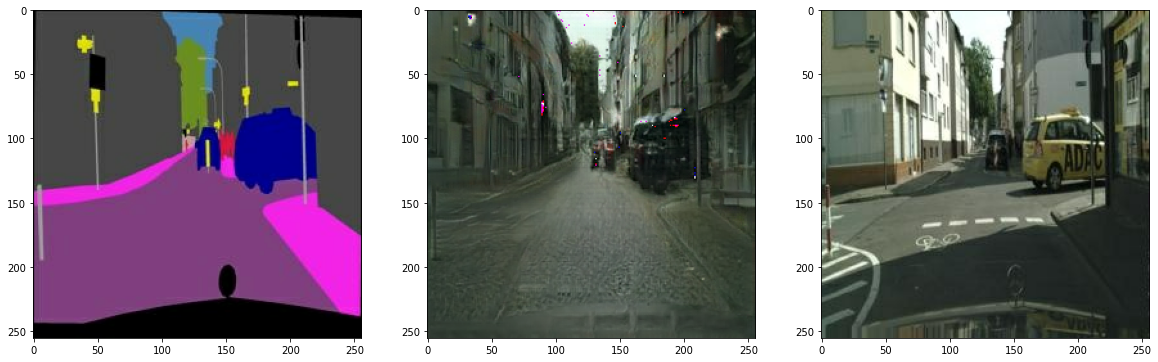

In [63]:
# 700epochs 학습 결과 테스트
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [60]:
generator.save('./data/models/generator_500epochs')

INFO:tensorflow:Assets written to: ./data/models/generator_500epochs\assets


INFO:tensorflow:Assets written to: ./data/models/generator_500epochs\assets


In [61]:
discriminator.save_weights('./data/models/discriminator_500epochs')

## 회고

- 에포크를 반복 할 수록 거리와 건물들은 눈에듸게 구체화 되는 것을 확인하였다. 
- 차량이 선명하게 생성되기를 바랬지만 흐물흐물 한 형태만 생성되고 선명하게 생성되지는 않은 것이 많이 아쉬웠다.
- 어느정도 학습이된 상태에서는 에포크를 증가시켜도 개선되지 않는 현상이 발생하고 있는 것으로 보인다. 총 700에포크를 돌려 보았지만 500에포크 이상에서는 개선이 되지 않는 것으로 보인다.
- 그림자와 도로표식 같은 아주 디테일 한 것 까지 생성되는 것은 무리가 있는 것 같이 보인다. 
- 여전히 코드를 완벽하게 이해 하는 것은 무리가 있다.
- 그래도 예전노드에서 gan을 집중해서 공부한 보람은 있는 것 같다.
- 딥러닝용 컴퓨터를 맞춘덕에 생각보다 짧은 시간에 학습을 할 수 있었다.
- 이제 익스 마지막 노드다. 좀 더 최선을 다하지 못한것이 아쉽지만 단 한개의 노드도 빼먹지 않고 진행한 것에 만족하기로 했다.